In [1]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings
warnings.filterwarnings("ignore")

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

![title](figs/title.png)

<h1><center>Module 07: Numerical Solutions to Parabolic PDEs</center></h1>

This module focuses on generating numerical solutions of **parabolic** partial differential equations (PDEs).  Recall that these types of second-order PDEs

$$Au_{xx}+2Bu_{xy}+Cu_{yy}+Du_{x}+Eu_{y}+Fu+G=0 \tag{1}$$

are defined by the condition $B^2-AC = 0$ (where $y$ is considered the $t$ variable and thus $A=E=1$ and all others are equal 0).

Three interesting examples (with increasing complexity) are the following:

   * **Heat Flow / Diffusion (Homogeneous medium)**: Used to model time-varying heat flow (or diffusive) phenomena with the rate of evolution is determined by the thermal conductivity $\kappa$ (or diffusivity). The solution $\phi=\phi(x,y,z,t)$ is known on the boundary of the solution domain $D$ (e.g., $\left. \phi\right|_{\partial D}=F(x,y,z)$) as is the initial distribution $\phi_0=\phi_0(x,y,z,t=0)$:
   
$$\frac{\partial \phi}{\partial t} = \kappa \nabla^2 \phi. \tag{3a}$$ 
   
   
   * **Heat Flow / Diffusion (Heterogeneous medium)**: This is like the example above, except now that the thermal conductivity (or diffusivity) is spatially varying, $\kappa = \kappa(x,y,z)$:

$$\frac{\partial \phi}{\partial t} =  \nabla \cdot \left(\kappa \nabla \phi \right). \tag{3b}$$ 
   
   
   * **Convection - Diffusion**:  These types of problems involve the types of heat flow (or diffusion) described above along with material transport at velocity ${\bf v} = [v_x,v_y,v_z]$ like we investigated in Module 4:
   
$$\frac{\partial \phi}{\partial t} + {\bf v} \cdot \nabla \phi =  \nabla \cdot \left(\kappa \nabla \phi \right). \tag{3c}$$ 

In the section below, we will look at generating solutions $\phi$ of the 1D and 2D heat flow / diffusion equation and then the 2D convection-diffusion equation throughout a computational domain $D$.  We will also examine different boundary conditions (BCs) on boundary of D (defined by shortform $\delta \Omega$), namely the Dirchelet BC

$$ \phi(\mathbf {x}) = f(\mathbf {x}), \quad \forall \mathbf {x}\in \delta \Omega$$

and the Neumann BC

$${\frac {\partial \phi}{\partial \mathbf {n} }}(\mathbf {x} )=f(\mathbf {x} )\quad \forall \mathbf {x} \in \partial \Omega $$

where ${\bf n}$ is a normal vector defined at the grid boundary that points inward.

## 1D Heat Flow

Let's start with one of the more straightforward examples: 1D heat flow in a thin uniform metal bar with constant thermal conductivity $\kappa$.  Let's say that the bar is of length $L$ in the $x$ direction, and is much thinner than $L$ in both of the $y$ and $z$ dimensions.  In this case, we can rewrite equation 3a with the following explict **partial differential equation (PDE)**:

$$\frac{\partial \phi}{\partial t} = \kappa \frac{\partial^2 \phi}{\partial x^2}. \tag{4}$$ 

For simplicity, let's say that the ends of the bar are fixed at some $\phi(x=0,t)=A^\circ$C and $\phi(x=L,t)=B^\circ$C, which represent homogeneous Dirichelet **boundary conditions**. Finally, let there be an **initial condition** where the temperature given by $\phi(x,t=0) = \phi_0(x)$. We can also say that the bar is perfectly thermally insulated along its length, and thus can only lose or gain heat at its ends. Thus, we have sufficient information to solve this heat flow problem.

### Numerical solution domain

To compute a numerical solution, let's first **discretize** the solution space.  In this case, we will segment the $x\in[0,L]$ into $nx+1$ discrete element spaced $dx = L/nx$ apart.  We will also break our time axis $t\in[0,t_{max}]$ into $nt+1$ steps where $dt=t_{max}/nt$.  This will give us the following example solution grid:

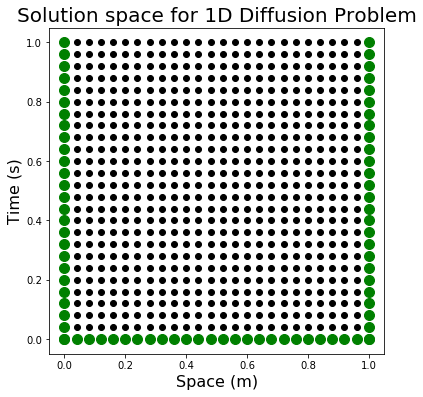

In [2]:
plt.figure(figsize=(6,6))
nx=nt=26
x = np.arange(nx)/(nx-1)
t=np.zeros(nt)

for it in range(nt):
    plt.plot(x,t,'ko')
    t+=1/(nt-1)
plt.plot(x,np.zeros(nx),'go',ms=10)
plt.plot(np.zeros(nt),x,'go',ms=10)
plt.plot(np.zeros(nx)+1,x,'go',ms=10)    
plt.ylabel('Time (s)',fontsize=16)
plt.xlabel('Space (m)',fontsize=16)
plt.title('Solution space for 1D Diffusion Problem',fontsize=20)
plt.show()

**Figure 1. Example solution space for 1D diffusion problem.  The green points are the locations where the solution is fixed by the initial condition (bottom) or the boundary conditions (left and right sides).  The black dots are the locations where we need to compute the solution.**

### Explicit FTCS solution

The first numerical solution that we will investigate is an explicit method: forward in time, centered in space (FTCS). This method uses an $\mathcal{O}(\Delta t)$ forward approximation for the temporal first derivative and an $\mathcal{O}(\Delta x^2)$ centered approximation for the spatial second derivative. Thus, this numerical approximation can be written as:

$$\frac{\phi^{n+1}_i -\phi^{n}_i}{\Delta t} = \kappa \frac{\left(\phi^{n}_{i+1}-2\phi^{n}_i+\phi^{n}_{i-1}  \right)}{\Delta x^2}.\tag{5}$$

Let's now multiply both sides by $\Delta t$ and then rearrange equation 5 so that we have all terms at the $n+1$ time step on the left-hand side, and all others on the right-hand side:

$$\phi^{n+1}_i = \alpha \phi^{n}_{i+1}+(1-2\alpha)\phi^{n}_i+\alpha\phi^{n}_{i-1}.\tag{6}$$

where $\alpha = \frac{\kappa \Delta t}{\Delta x^2}$ is introduced as a dimensionless number called the **diffusion number**.

Let's now code up a solver for this system:

In [22]:
def diffusion_ftcs_solver_homogeneous_Dirchelet(U,dx,dt,K,LB,RB):
    '''Set up FTCS Solver of the Diffusion equations
    usage: U = ADI_Solution(U,dx,dt,K,LB,RB)
    input: 
        U : Heat distribution vector (nx) at time t
        dx: Spatial sampling
        dt: Temporal sampling
        K : Thermal conductivity
        LB: Left  boundary (Homogeneous Dirchelet)
        RB: Right boundary (Homogeneous Dirchelet)
    output:
        U: Heat distribution vector (nx) at time t+∆t
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''        
    ## . . Get dimensions
    nx = len(U)
    
    ## . . Diffusion number
    alpha = K*dt/(dx*dx)
    
    ## . . Update solution vector
    U[1:nx-1] =      alpha *U[2:nx  ]+ \
                (1-2*alpha)*U[1:nx-1]+ \
                     alpha *U[0:nx-2]
            
    ## . . Enforce boundary conditions
    U[0   ] = LB
    U[nx-1] = RB
    
    return U

Let's also define the *diffusion_1D_animate(i)* animate function once so that we can call it frequently below:

In [23]:
def diffusion_1D_animate(i):
    global k
    ax1.clear()
    ax1.plot(xx,c[:,k],'g',xx,d[:,k],'b',linewidth=3)
    ax1.legend(['Copper','Iron'])
    ax1.grid(True)
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([-0.1*T0,1.1*T0])
    ax1.set(xlabel='Distance (m)',ylabel='Temperature ($^\circ$C)')
    ax1.set_title('Heat Flow at %f s'%(k*dt))
    k += kskip

### Copper and Iron Bars with Fixed Boundaries

Let's now create an example that calls our diffusion solver. We're going to discretize a solution domain $x\in[0,1]$m with $nx=51$ points ($dx=0.02$m) and $t\in[0,1]$s also with $nt=101$ points ($dt=0.01$s). As the initial distribution, let's use a Gaussian function

$$\phi_0(x) = 100 {\rm e}^{-(x-x_0)^2/(2\sigma^2)} \tag{7}$$

where $x_0=0.5$m, $\sigma=0.05$m and the units of $\phi$ are in $^\circ$C. For the thermal diffusivity, we are going to look at two materials:
   * Copper: $\kappa = 1.1 \times 10^{-4}$ m$^2/s$ (at $25^\circ$C)
   * Iron  : $\kappa = 2.3 \times 10^{-5}$ m$^2/s$

You'll note that the $\kappa$ values are defined at a constant temperature. Generally speaking, the thermal diffusivity of materials can depend on the temperature itself, which will make the problem **non-linear** and more difficult to solve.

In this scenario, you might recall that the steady-state solution would be for the bars to become uniformly $0^\circ$C. Let's see if our numerical solution accomplishes that:

In [28]:
## . . Time axis parameters
nt,dt=1001,1.5

## . . Space axis parameters
xmin,xmax=0,1
nx = 51
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition for copper and iron bars
sigma,midpoint,T0=0.05,(xmax-xmin)/2,100
Uc = np.zeros((nx))
Ui = np.zeros((nx))
Uc = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))
Ui = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))

## . . FD parameters
Kc       = 1.1*10**(-4) ## . . thermal diffusivity
Ki       = 2.3*10**(-5) ## . . thermal diffusivity
LB = RB = 0 ## . . Boundary conditions on left and right

print('alpha (Copper) =',Kc*dt/(dx*dx))
print('alpha (Iron  ) =',Ki*dt/(dx*dx))

c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

c[:,0]=Uc
d[:,0]=Ui
## . . Iterate over solution
for i in range(1,nt):
    ## . . run for copper bar
    Uc = diffusion_ftcs_solver_homogeneous_Dirchelet(Uc,dx,dt,Kc,LB,RB)
    c[:,i]=Uc
    ## . . run for iron bar
    Ui = diffusion_ftcs_solver_homogeneous_Dirchelet(Ui,dx,dt,Ki,LB,RB)
    d[:,i]=Ui
    
## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig1,ax1 = plt.subplots(1)
fig1.subplots_adjust(0.1,0.1,0.9,0.9)
fig1.set_dpi(100)

## . . Call the animator.  
anim1 = animation.FuncAnimation(fig1,diffusion_1D_animate,frames=int((nt-kskip)/kskip),interval=100)
anim1.save('./movies/Ex7_1.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex7_1.mp4" type="video/mp4">
</video>
""")

alpha (Copper) = 0.4125
alpha (Iron  ) = 0.08625


**Figure 2. Solutions of the 1D heat diffusion equation for an insulated 1m metal bar with the exposed ends held at 0ºC (i.e., zero Dirchelet boundary conditions). Solutions for copper (green) and iron (blue) are presented.**

### Playing with Boundary Conditions - Non-zero Dirichelet

Let's now look at the same example as above, but let's change the boundary conditions such that $\phi(x=0,t)=0^\circ$C and $\phi(x=1,t)=50^\circ$C.  Let's rerun the code from above:

In [29]:
## . . Time axis parameters
nt,dt=1201,1.5

## . . Space axis parameters
xmin,xmax=0,1
nx = 51
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition for copper and iron bars
sigma,midpoint,T0=0.05,(xmax-xmin)/2,100
Uc = np.zeros((nx))
Ui = np.zeros((nx))
Uc = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))
Ui = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))

## . . FD parameters
Kc       = 1.1*10**(-4) ## . . thermal diffusivity
Ki       = 2.3*10**(-5) ## . . thermal diffusivity
LB,RB = 0,50 ## . . Boundary conditions on left and right

print('alpha (Copper) =',Kc*dt/(dx*dx))
print('alpha (Iron  ) =',Ki*dt/(dx*dx))
## . . Iterate over solution
c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

c[:,0]=Uc
d[:,0]=Ui
for i in range(1,nt):
    ## . . run for copper bar
    Uc = diffusion_ftcs_solver_homogeneous_Dirchelet(Uc,dx,dt,Kc,LB,RB)
    c[:,i]=Uc
    ## . . run for iron bar
    Ui = diffusion_ftcs_solver_homogeneous_Dirchelet(Ui,dx,dt,Ki,LB,RB)
    d[:,i]=Ui
    
## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig2,ax1 = plt.subplots(1)
fig2.subplots_adjust(0.1,0.1,0.9,0.9)
fig2.set_dpi(100)

## . . Call the animator.  
anim2 = animation.FuncAnimation(fig2,diffusion_1D_animate,frames=int((nt-kskip)/kskip),interval=100)
anim2.save('./movies/Ex7_2.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex7_2.mp4" type="video/mp4">
</video>
""")

alpha (Copper) = 0.4125
alpha (Iron  ) = 0.08625


**Figure 3. Solutions of the 1D heat diffusion equation for an insulated 1m metal bar with the exposed ends held at 0ºC on the left and 50ºC on the right. (i.e., Dirchelet boundary conditions). Solutions for copper (green) and iron (blue) are presented.**

### Playing with boundary conditions - Neumann boundary conditions

The examples above looked at Dirichelet boundary conditions, which is where the boundaries are fixed at a certain value. However, there are important scenarios where you might want to control the heat gradient (i.e., $\frac{\partial \phi}{\partial x}$) at the boundary.

Let's say that we want to modify the above such that we had:

$$\frac{\partial \phi(x=0,t)}{\partial x}=A \tag{8}$$

We can think about applying this by discretizing equation 8 as:

$$\frac{U^n_1-U^n_0}{\Delta x} = A \tag{9a}$$

or solving for $U^n_0$:

$$U^n_0= U^n_1-A\Delta x. \tag{9b}$$

Similarly, at the right boundary we have

$$\frac{\partial \phi(x=L,t)}{\partial x}=B \tag{10}$$

and thus numerically we have:

$$\frac{U^n_N-U^n_{N-1}}{\Delta x} = B \tag{11a}$$

or solving for $U^n_N$:

$$U^n_N= U^n_{N-1}+B\Delta x. \tag{11b}$$

where the difference in sign in equations 9b and 11b is due to the opposing directions of normal derivative into the bar.  Let's redo our solver above but use Neumann BC's:

In [7]:
def diffusion_ftcs_solver_homogeneous_Neumann(U,dx,dt,K,LB,RB):
    '''Set up FTCS Solver of the Diffusion equations
    usage: U = ADI_Solution(U,dx,dt,K,LB,RB)
    input: 
        U : Heat distribution vector (nx) at time t
        dx: Spatial sampling
        dt: Temporal sampling
        K : Thermal conductivity
        LB: Left  boundary (Homogeneous Neuman)
        RB: Right boundary (Homogeneous Neuman)
    output:
        U: Heat distribution vector (nx) at time t+∆t
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''        
    ## . . Get dimensions
    nx = len(U)
    
    ## . . Diffusion number
    alpha = K*dt/(dx*dx)
    
    ## . . Update solution vector
    U[1:nx-1] =      alpha *U[2:nx  ]+ \
                (1-2*alpha)*U[1:nx-1]+ \
                     alpha *U[0:nx-2]
            
    ## . . Enforce boundary conditions
    U[0   ] = U[1   ]-LB*dx
    U[nx-1] = U[nx-2]+RB*dx
    
    return U

Let's now rerun the example above but with Neumann boundary conditions of $\frac{\partial \phi(x=0,t)}{\partial x}=1/\Delta x^\circ$C and $\frac{\partial \phi(x=1,t)}{\partial x}=0^\circ$C

In [8]:
## . . Time axis parameters
nt,dt=400,1.5

## . . Space axis parameters
xmin,xmax=0,1
nx = 51
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition for copper and iron bars
sigma,midpoint,T0=0.05,(xmax-xmin)/2,100
Uc = np.zeros((nx))
Ui = np.zeros((nx))
Uc = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))
Ui = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))

## . . FD parameters
Kc       = 1.1*10**(-4) ## . . thermal diffusivity
Ki       = 2.3*10**(-5) ## . . thermal diffusivity
LB,RB = -1/dx,0 ## . . Derivative Boundary conditions on left and right

print('alpha (Copper) =',Kc*dt/(dx*dx))
print('alpha (Iron  ) =',Ki*dt/(dx*dx))
## . . Iterate over solution
c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

for i in range(nt):
    ## . . run for copper bar
    Uc = diffusion_ftcs_solver_homogeneous_Neumann(Uc,dx,dt,Kc,LB,RB)
    c[:,i]=Uc
    ## . . run for iron bar
    Ui = diffusion_ftcs_solver_homogeneous_Neumann(Ui,dx,dt,Ki,LB,RB)
    d[:,i]=Ui
    
## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig3,ax1 = plt.subplots(1)
fig3.subplots_adjust(0.1,0.1,0.9,0.9)
fig3.set_dpi(100)

## . . Call the animator.  
anim3 = animation.FuncAnimation(fig3,diffusion_1D_animate,frames=int((nt-kskip)/kskip),interval=100)
anim3.save('./movies/Ex7_3.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex7_3.mp4" type="video/mp4">
</video>
""")

alpha (Copper) = 0.4125
alpha (Iron  ) = 0.08625


**Figure 3. Solutions of the 1D heat diffusion equation for an insulated 1m metal bar with the exposed ends experiencing a constant inward flux of (1/∆x)ºC/m on the left and 0ºC/m on the right. (i.e., Dirchelet boundary conditions). Solutions for copper (green) and iron (blue) are presented.**

## Stability of the FTCS method

One important consideration that have not discussed is whether or not the FTCS method is  **unconditionally stable** and, if not, under what conditions is it **conditionally stable**. You may have noticed that I have written out the values of $\alpha$ when running each example, and that the maximum value has been $\alpha=0.4125$ m$^2$/s.  Let's now redo the very first example but increase $dt=2$ such that maximum value (for copper) is now $\alpha=0.55$ m$^2$/s.

In [9]:
## . . Time axis parameters
nt,dt=101,2.2

## . . Space axis parameters
xmin,xmax=0,1
nx = 51
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition for copper and iron bars
sigma,midpoint,T0=0.05,(xmax-xmin)/2,100
Uc = np.zeros((nx))
Ui = np.zeros((nx))
Uc = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))
Ui = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))

## . . FD parameters
Kc       = 1.1*10**(-4) ## . . thermal diffusivity
Ki       = 2.3*10**(-5) ## . . thermal diffusivity
LB = RB = 0 ## . . Boundary conditions on left and right

print('alpha (Copper) =',Kc*dt/(dx*dx))
print('alpha (Iron  ) =',Ki*dt/(dx*dx))

c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

## . . Iterate over solution
for i in range(nt):
    ## . . run for copper bar
    Uc = diffusion_ftcs_solver_homogeneous_Dirchelet(Uc,dx,dt,Kc,LB,RB)
    c[:,i]=Uc
    ## . . run for iron bar
    Ui = diffusion_ftcs_solver_homogeneous_Dirchelet(Ui,dx,dt,Ki,LB,RB)
    d[:,i]=Ui
    
## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig4,ax1 = plt.subplots(1)
fig4.subplots_adjust(0.1,0.1,0.9,0.9)
fig4.set_dpi(100)

## . . Call the animator.  
anim4 = animation.FuncAnimation(fig4,diffusion_1D_animate,frames=int((nt-kskip)/kskip),interval=100)
anim4.save('./movies/Ex7_4.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex7_4.mp4" type="video/mp4">
</video>
""")

alpha (Copper) = 0.605
alpha (Iron  ) = 0.1265


**Figure 4. Solutions of the 1D heat diffusion equation as in Figure 3, except that the value of $\alpha$ for the copper bar has been increased to 0.605 instead of 0.4125.  Note that the copper bar simulation rapidly becomes unstable, where as the iron bar simulation remains stable ($\alpha=0.1265 m^2/s$).**

So it appears that we have crossed some sort of threshold between when $\alpha=0.4125$ m$^2$/s and $\alpha=0.55$ m$^2$/s. To examine this, let's again look at the von Neumann stability analysis that we discussed in Module 7.

## Von Neumann Stability Analysis

We want to investigate how the error difference $\epsilon^{n}$ between the true solution to the 1D diffusion PDE, $\phi_T$ and our numerical solution, $\phi$, changes from time step $n$ to $n+1$. Recall that this term is called the **amplification factor**

$$g^2 = \overline{g}g=\left|\frac{\epsilon^{n+1}_i}{\epsilon^n_i}\right|^2 \le 1, \tag{12}$$

Again, we can assume that the error term satisfies the discretization itself the amplification factor is given by:

$$g^2 = \left|\frac{\epsilon^{n+1}_i}{\epsilon^n_i}\right|^2 = \left|\frac{\alpha \epsilon^n_{i+1}+\left(1-2\alpha\right)\epsilon^n_i+\alpha \epsilon^n_{i-1} }{\epsilon^n_i}\right|^2 \le 1  \tag{14}$$

We now can assume that each term can be represented by 

$$\epsilon^n = A_n e^{ik x}, \tag{15}$$

where $A^n$ is an amplitude term at time step $n$ such that 

$$\epsilon^n_i     = A_n e^{ik x},            \tag{16a}$$
$$\epsilon^n_{i+1} = A_n e^{ik (x+\Delta x)}, \tag{16b}$$
$$\epsilon^n_{i-1} = A_n e^{ik (x-\Delta x)}. \tag{16c}$$

Inserting these into equation 14 yields

$$g^2 = 
\left|\frac{\alpha A_n e^{ik (x+\Delta x)}+
\left(1-2\alpha\right)A_n e^{ik x}+
\alpha A_n e^{ik (x-\Delta x)}}
{A_n e^{ik x}}  \right|^2 \le 1
\tag{17}$$

which simplifies to 

$$
\begin{eqnarray}
g^2 &=& 
\left|\alpha e^{ik\Delta x}+
\left(1-2\alpha\right)+
\alpha e^{-ik\Delta x} \right|^2\le 1\\
&=& \left|1+2\alpha\,(\cos\left(k\Delta x\right)-1)\right|^2 \le 1\\
&=& \left|1-4\alpha \sin^2\left(\frac{k\Delta x}{2}\right)\right|^2 \le 1
\end{eqnarray}
\tag{18}$$

where in the last step we have used the half-angle formula $2\sin^2 \theta =1-\cos 2\theta$.  Thus, the **stability criterion** for this numerical scheme is given by

$$g^2=\left|1-4\alpha \sin^2\left(\frac{k\Delta x}{2}\right)\right|^2\le 1. \tag{19}$$

Note that the $\sin^2$ factor ranges between 0 and 1; when it is 0 this criterion is always satisfied.  Thus, we are interested in the maximal case when $\sin^2=1$.  Accordingly, we rewrite the inequality in equation 18 as

$$g^2 = \left|1-4\alpha\right|^2 \le 1, \tag{20}$$

which is satisfied in the range when $\alpha\in[0,1/2]$.  Thus, we have the following restriction on the numerical simulation:

$$\alpha = \frac{\kappa \Delta t}{\Delta x^2} < \frac{1}{2} \tag{21}$$

or for a more explicit constraint on the allowed time step $\Delta t$:

$$\Delta t < \frac{\Delta x^2}{2\kappa}, \tag{22}$$

which is consistent with the numerical simulations above. Thus, while the above FTCS approach is relatively straightforward to implement, it suffers from the severe drawback that it is only **conditionally stable**. This motivates use to look for other numerical methods that are **unconditionally stable**.

# The Implicit Crank-Nicholson method

Fortunately, we do not have to look too far to find such a method. The Crank-Nicholson (CN) method represents an extension of the FTCS approach that is $\mathcal{O}\left(\Delta t^2,\Delta x^2\right)$ and **unconditionally stable**.  The main idea behind this approach is that unlike the FTCS method that defines a forward-difference formula for **one unknown point** at time step $n+1$, the CN method specifies it for **three unknown points** at time step $n+1$ in the FD stencil. Figure 9-5 below illustrates the stencil associated with this numerical scheme.

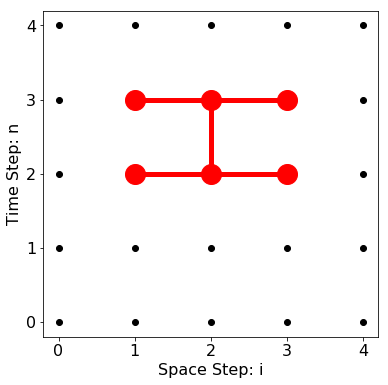

In [10]:
plt.figure(figsize=(6,6))
nx=ny=5
x = np.arange(nx)
y=np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
plt.plot(1,2,'ro',ms=20)
plt.plot(2,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot(1,3,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot(3,3,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot([1,3],[3,3],'r-',linewidth=5)
plt.plot([2,2],[2,3],'r-',linewidth=5)

plt.ylabel('Time Step: n',fontsize=16)
plt.yticks(range(5),fontsize=16)
plt.xlabel('Space Step: i',fontsize=16)
plt.xticks(range(5),fontsize=16)
plt.show()

**Figure 5. Illustration of the Crank-Nicholson stencil where known values at time step $n=2$ are used to calculate solutions at time step $n=3$.**

As we see in the above figure, we now have a system where we have three unknown at time step $n+1$ for each location of the stencil.  However, if you shift the stencil one step to the left and right, you will also have constraint equations that can be used to help solve for the unknown forward value at $[i,n]=[2,3]$.

### CN Numerical Scheme

The CN numerical scheme is based on taking an equally weighted average of the points at time step $n$ and $n+1$ for approximating the second spatial derivative. We can write the CN numerical scheme in the following way:

$$\frac{\phi^{n+1}_i -\phi^{n}_i}{\Delta t} = 
\frac{\kappa}{2}
\left( 
\frac{
\phi^{n+1}_{i+1}-2\phi^{n+1}_i+\phi^{n+1}_{i-1} + 
\phi^{n}_{i+1}-2\phi^{n}_i+\phi^{n}_{i-1}
}{\Delta x^2}
\right)
.\tag{23}$$

Again, by defining $\alpha=\frac{\kappa \Delta t}{\Delta x^2}$, we can rearrange equation 23 as

$$2\left(\phi^{n+1}_i -\phi^{n}_i\right) = 
\alpha
\left( 
\phi^{n+1}_{i+1}-2\phi^{n+1}_i+\phi^{n+1}_{i-1} + 
\phi^{n}_{i+1}-2\phi^{n}_i+\phi^{n}_{i-1}
\right),
\tag{24}$$

and then move the $n+1$ and $n$ terms to the left- and right-hand sides, respectively:

$$-\alpha\phi^{n+1}_{i+1}+2(1+\alpha)\phi^{n+1}_{i}-\alpha\phi^{n+1}_{i-1}=
\alpha\phi^{n}_{i+1}+2(1-\alpha)\phi^{n}_{i}+\alpha\phi^{n}_{i-1}. \tag{25}$$

While this seems quite a bit more complicated, we have actually a similar system in Module 8!  To illustrate this, let's write this in a linear algebra framework in the standard form of ${\bf Ax}={\bf b}$:


$$
\left[
\begin{array}{ccccccc}
2(1+\alpha) & -\alpha & 0 & 0 & ... & 0&0 &0 &0 \\
-\alpha & 2(1+\alpha) & -\alpha & 0 &... & 0&0  &0 &0 \\
0 & -\alpha & 2(1+\alpha) & -\alpha & ... & 0&0 &0 &0 \\
\vdots & \vdots & \vdots& \vdots & \ddots & \vdots &\vdots &\vdots & \vdots\\
0 &0&0&0&...&-\alpha&2(1+\alpha)&-\alpha&0\\
0 &0&0&0&...&0&-\alpha&2(1+\alpha)&-\alpha\\
0 &0&0&0&...&0&0&-\alpha&2(1+\alpha)\\
\end{array}
\right]
\left[
\begin{array}{c}
u^{n+1}_{1} \\
u^{n+1}_{2} \\
u^{n+1}_{3} \\
\vdots\\
u^{n+1}_{I-3} \\
u^{n+1}_{I-2} \\
u^{n+1}_{I-1} \\
\end{array}
\right]
=
\left[
\begin{array}{c}
\alpha\phi^{n}_{2}+2(1-\alpha)\phi^{n}_{1}+\alpha(\phi^{n}_{0}+\phi^{n+1}_{0}) \\
\alpha\phi^{n}_{3}+2(1-\alpha)\phi^{n}_{2}+\alpha\phi^{n}_{1} \\
\alpha\phi^{n}_{4}+2(1-\alpha)\phi^{n}_{3}+\alpha\phi^{n}_{2} \\
\vdots\\
\alpha\phi^{n}_{I-2}+2(1-\alpha)\phi^{n}_{I-3}+\alpha\phi^{n}_{I-4} \\
\alpha\phi^{n}_{I-1}+2(1-\alpha)\phi^{n}_{I-2}+\alpha\phi^{n}_{I-3} \\
\alpha(\phi^{n}_{I  }+\phi^{n+1}_{I})+2(1-\alpha)\phi^{n}_{I-1}+\alpha\phi^{n}_{I-2} \\
\end{array}
\right]. \tag{26}
$$

Here we see that modeling matrix ${\bf A}$ is a **banded matrix** on the main, super- and subdiagonal. Thus, this system of equations again represents a **tridiagonal system** that can be solved using standard methods of linear algebra!  Also, note the first and last entries in known solution vector ${\bf b}$ contain the terms $\phi^n_0$, and $\phi^{n+1}_0$ (first row) and $\phi^n_{I}$ and $\phi^{n+1}_{I}$ (last row). This is because these values are known and are used to represent the **boundary conditions**.


### Solution by Thomas Algorithm

Previously, we have solved systems of equations like those in equation 26 using a "brute force" method of *np.linalg.solve(Ax,bx)*, which computes the “exact” solution, ${\bf x}$, of the well-determined, i.e., full rank, linear matrix equation ${\bf Ax} = {\bf b}$. However, it should be pretty clear that the FD matrix ${\bf A}$ is actually very **sparse** and has **banded structure**.  Thus, it is judicious to ask whether there are any more efficient numerical methods that can take advantage of this matrix structure.  

Since you have seen the title of this subsection, you have probably surmised that the answer is yes.  Let's investigate the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm), which can be used to solve certain tridiagonal systems (i.e., a [diagonally dominant matrix](https://en.wikipedia.org/wiki/Diagonally_dominant_matrix)) defined by:

$$a_{i}x_{i-1}+b_{i}x_{i}+c_{i}x_{i+1}=d_{i}, \tag{27a}$$

where ${a_{1}=0}$ and $c_{n}=0$ and written in matrix form as

$${\begin{bmatrix}{b_{1}}&{c_{1}}&{}&{}&{0}\\{a_{2}}&{b_{2}}&{c_{2}}&{}&{}\\{}&{a_{3}}&{b_{3}}&\ddots &{}\\{}&{}&\ddots &\ddots &{c_{n-1}}\\{0}&{}&{}&{a_{n}}&{b_{n}}\\\end{bmatrix}}{\begin{bmatrix}{x_{1}}\\{x_{2}}\\{x_{3}}\\\vdots \\{x_{n}}\\\end{bmatrix}}={\begin{bmatrix}{d_{1}}\\{d_{2}}\\{d_{3}}\\\vdots \\{d_{n}}\\\end{bmatrix}}.\tag{28b}$$

This algorithm uses a two-step approach involving a forward and then a backward "sweep" calculation. The forward sweep consists of modifying the coefficients as follows, denoting the new coefficients with primes:

$${\displaystyle c'_{i}={\begin{cases}{\begin{array}{lcl}{\cfrac {c_{i}}{b_{i}}}&;&i=1\\{\cfrac {c_{i}}{b_{i}-a_{i}c'_{i-1}}}&;&i=2,3,\dots ,n-1\\\end{array}}\end{cases}}\,} \tag{29a}$$

and

$$d'_{i}=
{\begin{cases}
{\begin{array}{lcl}{\cfrac {d_{i}}{b_{i}}}&;&i=1\\{\cfrac {d_{i}-a_{i}d'_{i-1}}{b_{i}-a_{i}c'_{i-1}}}&;&i=2,3,\dots ,n.\\
\end{array}}
\end{cases}} \tag{29b}
$$
The solution is then obtained by back substitution:

$$ x_{n}=d'_{n} \tag{30a}$$

and

$$ x_{i}=d'_{i}-c'_{i}x_{i+1}\quad \ i=n-1,n-2,\ldots ,1. \tag{30b}$$

Let's now implement the Thomas algorithm using two different functions.  The first function *TDMAsolver(a,b,c,d)* implements the Thomas Algorithm solution, while the second function *Solve_Tridiagonal_homogeneous_Thomas(a,b,c,d)* sets up the coefficients to be passed to the *TDMAsolver*.

In [11]:
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays

    ## . . Forward sweep
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
    
    ## . . Backsubstitution sweep
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [12]:
def Solve_Diffusion_homogeneous_Thomas(U,K,dx,dt,LB,RB):
    '''Set up tridiagonal matrix and call Thomas Algorithm 
    usage: x = Solve_Diffusion_homogeneous_Thomas(U,K,dx,dt,LB,RB):
    input: 
        U: heat solution at time step n   (nx)
        K : thermal conductivity
        dx: spatial sampling
        dt: temporal sampling
        LB: Left  boundary condition (Dirchelet)
        RB: Right boundary condition (Dirchelet)
    output:
        U: heat solution at time step n+1 (nx)
    depends on:
        TDMAsolver
    
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    n = len(U)
    
    alpha = K*dt/(dx*dx)
    
    ## . . Set up coefficients
    aa =     -alpha *np.ones(n)
    bb = 2*(1+alpha)*np.ones(n)
    cc =     -alpha *np.ones(n)
    
    ## . . Treat ends
    aa[0  ]=0
    cc[n-1]=0
    
    ## . . Set up known right-hand side solution matrix
    dd = np.zeros((nx))
    
    dd[1:nx-2] =     alpha *U[2:nx-1]+\
                2*(1-alpha)*U[1:nx-2]+\
                     alpha *U[0:nx-3]
    dd[1   ]+=alpha*U[0   ]
    dd[nx-2]+=alpha*U[nx-1]
    
    ## . . Call Solver to update solution
    U = TDMAsolver(aa, bb, cc, dd)
    
    return U

Let's now redo the scenario from above that proved to be unstable with $dt=2$ and $\alpha=0.55$m$^2$/s, but go back to simple Dirchelet boundary conditions where $\phi(x=0,t)=\phi(x=1,t)=0$.

In [13]:
## . . Time axis parameters
nt,dt=400,2

## . . Space axis parameters
xmin,xmax=0,1
nx = 51
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition for copper and iron bars
sigma,midpoint,T0=0.05,(xmax-xmin)/2,100
Uc = np.zeros((nx))
Ui = np.zeros((nx))
Uc = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))
Ui = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))

## . . FD parameters
Kc       = 1.1*10**(-4) ## . . thermal diffusivity
Ki       = 2.3*10**(-5) ## . . thermal diffusivity
LB,RB = 0,0 ## . . Derivative Boundary conditions on left and right

print('alpha (Copper) =',Kc*dt/(dx*dx))
print('alpha (Iron  ) =',Ki*dt/(dx*dx))
## . . Iterate over solution
c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

for i in range(nt):
    ## . . run for copper bar
    Uc = Solve_Diffusion_homogeneous_Thomas(Uc,Kc,dx,dt,LB,RB)
    c[:,i]=Uc
    ## . . run for iron bar
    Ui = Solve_Diffusion_homogeneous_Thomas(Ui,Ki,dx,dt,LB,RB)
    d[:,i]=Ui

## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig5,ax1 = plt.subplots(1)
fig5.subplots_adjust(0.1,0.1,0.9,0.9)
fig5.set_dpi(100)

## . . Call the animator.  
anim5 = animation.FuncAnimation(fig5,diffusion_1D_animate,frames=int((nt-kskip)/kskip),interval=100)
anim5.save('./movies/Ex7_5.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex7_5.mp4" type="video/mp4">
</video>
""")

alpha (Copper) = 0.55
alpha (Iron  ) = 0.115


**Figure 6. Movie showing the same example as in Figure 4, but using a Crank-Nicholson solver with dt=2.0s.  We see that the CN approach does not suffer from any (apparent) numerical instabilities.**

Let's now rerun the solution above, but increase the time step to, say, $\Delta t=20$s:

In [14]:
## . . Time axis parameters
nt,dt=400,20

## . . Space axis parameters
xmin,xmax=0,1
nx = 51
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition for copper and iron bars
sigma,midpoint,T0=0.05,(xmax-xmin)/2,100
Uc = np.zeros((nx))
Ui = np.zeros((nx))
Uc = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))
Ui = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))

## . . FD parameters
Kc       = 1.1*10**(-4) ## . . thermal diffusivity
Ki       = 2.3*10**(-5) ## . . thermal diffusivity
LB,RB = 0,0 ## . . Derivative Boundary conditions on left and right

print('alpha (Copper) =',Kc*dt/(dx*dx))
print('alpha (Iron  ) =',Ki*dt/(dx*dx))

## . . Iterate over solution
c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

for i in range(nt):
    ## . . run for copper bar
    Uc = Solve_Diffusion_homogeneous_Thomas(Uc,Kc,dx,dt,LB,RB)
    c[:,i]=Uc
    ## . . run for iron bar
    Ui = Solve_Diffusion_homogeneous_Thomas(Ui,Ki,dx,dt,LB,RB)
    d[:,i]=Ui
    
## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig6,ax1 = plt.subplots(1)
fig6.subplots_adjust(0.1,0.1,0.9,0.9)
fig6.set_dpi(100)

## . . Call the animator.  
anim6 = animation.FuncAnimation(fig6,diffusion_1D_animate,frames=int((nt-kskip)/kskip),interval=100)
anim6.save('./movies/Ex7_6.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex7_6.mp4" type="video/mp4">
</video>
""")

alpha (Copper) = 5.5
alpha (Iron  ) = 1.15


**Figure 7. Movie showing the same example as in Figure 4, but using a Crank-Nicholson solver with ∆t=20.0s.  We see that the CN approach does not suffer from any (apparent) numerical instabilities.**

### Importance of CN method

There are a number of different factors that have come to light in this series of investigations:

   * **Unconditional Stability** - The CN method allows you to run simulations that are guaranteed to be stable, which can be shown to be the following through a von Neumann staility analysis for all values of $\alpha$:

$$g^2 = \left| \frac{1-2\alpha \sin^2(\gamma/2)}{1+2\alpha \sin^2(\gamma/2)} \right|^2 \le 1\tag{31}$$

   * **Large time-stepping** - We have seen that we can use large $\Delta t$ time steps, which means that it is much quicker to forward simulate the numerical solution to the steady-state solution (if there is one!).
   * **Reduced computational complexity** - The computational complexity of the Thomas Algorithm is $\mathcal{O}(nx)$ compared to $O(nx^3)$ for Gaussian elimination, which means that this approach scales much better as $nx$ gets very large.

# Solving the 1D Convection-Diffusion equation

The 1D convection-diffusion equation for a convective velocity $v_x$ and diffusivity $\kappa$ is given by:

$$\frac{\partial \phi}{\partial t} + v_x \frac{\partial \phi}{\partial x} = \kappa \frac{\partial^2 \phi}{\partial x^2} \tag{32}$$

which is subject to some initial condition

$$\phi(x,t=0)= \phi_0(x). \tag{33}$$

Here, both the convection velocity $v_x$ and diffusivity $\kappa$ are assumed to be constant.

## Crank-Nicholson Numerical Approach

Let's take the Crank-Nicholson approach that we learned in the section above and apply it to the the 1D convection-diffusion equation.  This leads to the following discretized equation

$$\frac{\phi^{n+1}_i-\phi^n_i}{\Delta t} + \frac{v_x}{2} \left(\frac{\phi^{n+1}_{i+1}-\phi^{n+1}_{i-1}}{2\Delta x}+\frac{\phi^{n}_{i+1}-\phi^{n}_{i-1}}{2\Delta x} \right) 
=
\frac{\kappa}{2}
\left(
 \frac{
\phi^{n+1}_{i+1}-2\phi^{n+1}_i+\phi^{n+1}_{i-1} + 
\phi^{n}_{i+1}-2\phi^{n}_i+\phi^{n}_{i-1}
}{\Delta x^2}
\right)
\tag{34}$$

Let's now multiply through by $\Delta t$ 

$$\phi^{n+1}_i - \phi^n_i + \frac{v_x \Delta t}{4\Delta x} \left(\phi^{n+1}_{i+1}-\phi^{n+1}_{i-1}+\phi^{n}_{i+1}-\phi^{n}_{i-1} \right) 
=
\frac{\kappa \Delta t}{2\Delta x^2}
\left(
\phi^{n+1}_{i+1}-2\phi^{n+1}_i+\phi^{n+1}_{i-1} + 
\phi^{n}_{i+1}-2\phi^{n}_i+\phi^{n}_{i-1}
\right),
\tag{35a}$$

and use the following subsitutions of the Courant number $C = \frac{v_x \Delta t}{\Delta x}$ and the diffusion number $\alpha = \frac{\kappa \Delta t}{\Delta x^2}$ and multiply through by 4 such that 

$$4\phi^{n+1}_i - 4\phi^n_i + C \left(\phi^{n+1}_{i+1}-\phi^{n+1}_{i-1}+\phi^{n}_{i+1}-\phi^{n}_{i-1} \right) 
=
2\alpha
\left(
\phi^{n+1}_{i+1}-2\phi^{n+1}_i+\phi^{n+1}_{i-1} + 
\phi^{n}_{i+1}-2\phi^{n}_i+\phi^{n}_{i-1}
\right).
\tag{35b}$$

Let's now bring all of the $n+1$ terms to the left and all of the $n$ terms to the right:

$$4\phi^{n+1}_i + C \phi^{n+1}_{i+1}-C\phi^{n+1}_{i-1} 
-2\alpha\phi^{n+1}_{i+1}+4\alpha\phi^{n+1}_i-2\alpha\phi^{n+1}_{i-1} 
=
4\phi^n_i
-C\phi^{n}_{i+1}
+C\phi^{n}_{i-1}
+2\alpha\phi^{n}_{i+1}-4\alpha\phi^{n}_i+2\alpha\phi^{n}_{i-1}.
\tag{35c}$$

Now let's collect like terms to yield

$$(C-2\alpha) \, \phi^{n+1}_{i+1}
+4(1+\alpha) \, \phi^{n+1}_i 
-(C+2\alpha)\,\phi^{n+1}_{i-1} 
=
- (C-2\alpha)\,\phi^{n}_{i+1}
+4(1-\alpha)\,\phi^n_i
+(C+2\alpha)\,\phi^{n}_{i-1}.
\tag{35d}$$

Again, we see that even though the resulting discretized system is more complex, it is still represented by a tridiagonal system!  

Let's look at the resulting system in a linear algebra framework

$$
\left[
\begin{array}{ccccccc}
4(1+\alpha) & (C-2\alpha) & 0 & 0 & ... & 0&0 &0 &0 \\
-(C+2\alpha) & 4(1+\alpha) & (C-2\alpha) & 0 &... & 0&0  &0 &0 \\
0 &-(C+2\alpha) & 4(1+\alpha) & (C-2\alpha)& ... & 0&0 &0 &0 \\
\vdots & \vdots & \vdots& \vdots & \ddots & \vdots &\vdots &\vdots & \vdots\\
0 &0&0&0&...&-(C+2\alpha)&4(1+\alpha)&(C-2\alpha)&0\\
0 &0&0&0&...&0&-(C+2\alpha)&4(1+\alpha)&(C-2\alpha)\\
0 &0&0&0&...&0&0&-(C+2\alpha)&4(1+\alpha)\\
\end{array}
\right]
\left[
\begin{array}{c}
u^{n+1}_{1} \\
u^{n+1}_{2} \\
u^{n+1}_{3} \\
\vdots\\
u^{n+1}_{I-3} \\
u^{n+1}_{I-2} \\
u^{n+1}_{I-1} \\
\end{array}
\right]
=
\left[
\begin{array}{c}
- (C-2\alpha)\,\phi^{n}_{2}+4(1-\alpha)\,\phi^n_1+(C+2\alpha)\,(\phi^{n}_{0}+ \phi^{n+1}_{0})\\
- (C-2\alpha)\,\phi^{n}_{3}+4(1-\alpha)\,\phi^n_2+(C+2\alpha)\,\phi^{n}_{1} \\
- (C-2\alpha)\,\phi^{n}_{4}+4(1-\alpha)\,\phi^n_3+(C+2\alpha)\,\phi^{n}_{2} \\
\vdots\\
- (C-2\alpha)\,\phi^{n}_{I-2}+4(1-\alpha)\,\phi^n_{I-3}+(C+2\alpha)\,\phi^{n}_{I-4} \\
- (C-2\alpha)\,\phi^{n}_{I-1}+4(1-\alpha)\,\phi^n_{I-2}+(C+2\alpha)\,\phi^{n}_{I-3} \\
- (C-2\alpha)\,(\phi^{n}_{I  }+\phi^{n+1}_{I})+4(1-\alpha)\,\phi^n_{I-1}+(C+2\alpha)\,\phi^{n}_{I-2} \\
\end{array}
\right]. \tag{36}
$$

In [15]:
def Solve_Convection_Diffusion_homogeneous_Thomas(U,K,vx,dx,dt,LB,RB):
    '''Set up tridiagonal matrix and call Thomas Algorithm 
    usage: x = Solve_Tridiagonal(a,b,c,u):
    input: 
        u: heat solution at time step n   (nx)
        K : thermal diffusivity
        vx: convection velocity
        dx: spatial sampling
        dt: temporal sampling
        LB: Left  boundary condition (Dirchelet)
        RB: Right boundary condition (Dirchelet)
    output:
        u: heat solution at time step n+1 (nx)
    depends on:
        TDMAsolver
    
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    n = len(U)
    
    AA = K *dt/(dx*dx) ## Diffusivity: alpha
    CC = vx*dt/ dx     ## Courant :C
    
    ## . . Set up coefficients
    aa =-(CC+2*AA)*np.ones(n)
    bb =  4*(1+AA)*np.ones(n)
    cc = (CC-2*AA)*np.ones(n)
    
    ## . . Treat ends
    aa[0  ]=0
    cc[n-1]=0
    
    ## . . Set up known solution matrrix
    dd = np.zeros((nx))
    dd[1:nx-2] = -(CC-2*AA)*U[2:nx-1]+\
                   4*(1-AA)*U[1:nx-2]+\
                 +(CC+2*AA)*U[0:nx-3]
    dd[1   ]+=+(CC+2*AA)*U[0   ]
    dd[nx-1]+=-(CC-2*AA)*U[nx-1]
    U = TDMAsolver(aa, bb, cc, dd)
    
    return U

In [16]:
def convection_diffusion_1D_animate(i):
    global k
    ax1.clear()
    ax1.plot(xx,c[:,k],'g',xx,d[:,k],'b',linewidth=3)
    ax1.legend(['Fast Diff','Slow Diff'])
    ax1.grid(True)
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([-0.1*T0,1.1*T0])
    ax1.set(xlabel='Distance (m)',ylabel='Temperature ($^\circ$C)')
    ax1.set_title('Heat Flow at %f s'%(k*dt))
    k += kskip    

In [17]:
## . . Time axis parameters
nt,dt=600,1

## . . Space axis parameters
xmin,xmax=0,1
nx = 101
xx = np.linspace(xmin,xmax,nx)
dx = xx[1]-xx[0]

## . . Initial Condition for copper and iron bars
sigma,midpoint,T0=0.05,(xmax-xmin)/4,100
Uc = np.zeros((nx))
Ui = np.zeros((nx))
Uc = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))
Ui = T0*np.exp(-(xx-midpoint)**2/(2*sigma**2))

## . . FD parameters
Kf = 0.01 ## . . thermal fast
Ks = 0.0001 ## . . thermal slow
vx = 0.002
LB,RB = 0,0 ## . . Derivative Boundary conditions on left and right

print('diffusion #: alpha (fast) =',Kf*dt/(dx*dx))
print('diffusion #: alpha (slow) =',Ks*dt/(dx*dx))
print('Courant   #: C =',vx*dt/dx)

## . . Iterate over solution
c = np.zeros((nx,nt))
d = np.zeros((nx,nt))

for i in range(nt):
    ## . . run for copper bar
    Uc = Solve_Convection_Diffusion_homogeneous_Thomas(Uc,Kc,vx,dx,dt,LB,RB)
    c[:,i]=Uc
    ## . . run for iron bar
    Ui = Solve_Convection_Diffusion_homogeneous_Thomas(Ui,Ki,vx,dx,dt,LB,RB)
    d[:,i]=Ui
    
## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig7,ax1 = plt.subplots(1)
fig7.subplots_adjust(0.1,0.1,0.9,0.9)
fig7.set_dpi(100)

## . . Call the animator.  
anim7 = animation.FuncAnimation(fig7,convection_diffusion_1D_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim7.save('./movies/Ex7_7.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex7_7.mp4" type="video/mp4">
</video>
""")

diffusion #: alpha (fast) = 100.0
diffusion #: alpha (slow) = 1.0
Courant   #: C = 0.2


**Figure 8. Solution of the 1D convection-diffusion equation for both slow (blue) and fast (green) diffusion coefficients.**

## Solving the 2D Convection-Diffusion Equation

Let's now look at expanding our dimensionality to cover the 2D convection-diffusion equation.  This equation is given in general by the following:

$$\frac{\partial \phi}{\partial t} + {\bf v} \cdot \nabla \phi = \kappa \nabla^2 \phi, \tag{37a}$$

and with specific Cartesian partial derivatives

$$\frac{\partial \phi}{\partial t} + v_x \frac{\partial \phi}{\partial x} + v_y \frac{\partial \phi}{\partial y}= \kappa \left(\frac{\partial^2 \phi}{\partial x^2}+\frac{\partial^2 \phi}{\partial y^2} \right).\tag{37b}$$

Given that we (1) know how to solve the 1D convection-diffusion equation from above and (2) used an alternating direction implict (ADI) solver in Module 8, we might expect that their combination presents us with a two-step procedure to solve the 2D convection-diffusion equation

### Step 1 - First half-step in x direction

The first half step provides the following update in the $x$ direction:

$$\frac{\phi^{n+1/2}_{i,j}-\phi^n_{i,j}}{\Delta t/2} + v_x \left(\frac{\phi^{n+1/2}_{i+1,j}-\phi^{n+1/2}_{i-1,j}}{2\Delta x}\right) + v_y \left(\frac{\phi^{n}_{i,j+1}-\phi^{n}_{i,j-1}}{2\Delta y} \right) 
=
\kappa
\left(
\frac{\phi^{n+1/2}_{i+1,j}-2\phi^{n+1/2}_{i,j}+\phi^{n+1/2}_{i-1,j}}{\Delta x^2} + 
\frac{\phi^{n}_{i,j+1}-2\phi^{n}_{i,j}+\phi^{n}_{i,j-1}}{\Delta y^2}
\right)
\tag{38}$$

Multiplying through by $2\Delta t$ and then using $C_x = \frac{v_x\Delta t}{\Delta x}$, $C_y = \frac{v_y\Delta t}{\Delta y}$, $\alpha_x = \frac{\kappa \Delta t}{\Delta x^2}$, and $\alpha_y = \frac{\kappa \Delta t}{\Delta y^2}$ leads to

$$4\phi^{n+1/2}_{i,j}-4\phi^n_{i,j} 
+ C_x\left(\phi^{n+1/2}_{i+1,j} - \phi^{n+1/2}_{i-1,j}\right) 
+C_y\left(\phi^{n}_{i,j+1}-\phi^{n}_{i,j-1} \right) 
=
2\alpha_x \left(\phi^{n+1/2}_{i+1,j}-2\phi^{n+1/2}_{i,j}+\phi^{n+1/2}_{i-1,j}\right) +
2\alpha_y \left(\phi^{n}_{i,j+1}-2\phi^{n}_{i,j}+\phi^{n}_{i,j-1}\right)
\tag{39}$$

Collecting like terms and moving those dependent on time step $n+1/2$ to the left-hand side and $n$ to the right-hand side results in

$$
(C_x-2\alpha_x)\phi^{n+1/2}_{i+1,j}
+4(1+\alpha_x)\phi^{n+1/2}_{i,j} 
-(C_x+2\alpha_x)\phi^{n+1/2}_{i-1,j} 
=
-(C_y-2\alpha_y)\phi^{n}_{i,j+1}
+4(1-\alpha_y)\phi^{n}_{i,j}
+(C_y+2\alpha_y)\phi^{n}_{i,j-1} 
\tag{40}$$

which is a tridiagonal matrix as is expected.

### Step 2 - Second half-step in y direction

The second half step provides the following update in the y direction:

$$\frac{\phi^{n+1}_{i,j}-\phi^{n+1/2}_{i,j}}{\Delta t/2} 
+ v_x \left(\frac{\phi^{n+1/2}_{i+1,j}-\phi^{n+1/2}_{i-1,j}}{2\Delta x}\right) 
+ v_y \left(\frac{\phi^{n+1  }_{i,j+1}-\phi^{n+1  }_{i,j-1}}{2\Delta y}\right) 
=
\kappa
\left(
\frac{\phi^{n+1/2}_{i+1,j}-2\phi^{n+1/2}_{i,j}+\phi^{n+1/2}_{i-1,j}}{\Delta x^2} + 
\frac{\phi^{n+1  }_{i,j+1}-2\phi^{n+1  }_{i,j}+\phi^{n+1  }_{i,j-1}}{\Delta y^2}
\right)
\tag{41}$$

Multiplying through by $2\Delta t$ and again using $C_x = \frac{v_x\Delta t}{\Delta x}$, $C_y = \frac{v_y\Delta t}{\Delta y}$, $\alpha_x = \frac{\kappa \Delta t}{\Delta x^2}$, and $\alpha_y = \frac{\kappa \Delta t}{\Delta y^2}$ leads to

$$4\phi^{n+1}_{i,j}-4\phi^{n+1/2}_{i,j} 
+ C_x\left(\phi^{n+1/2}_{i+1,j} - \phi^{n+1/2}_{i-1,j}\right) 
+C_y\left(\phi^{n+1}_{i,j+1}-\phi^{n+1}_{i,j-1} \right) 
=
2\alpha_x \left(\phi^{n+1/2}_{i+1,j}-2\phi^{n+1/2}_{i,j}+\phi^{n+1/2}_{i-1,j}\right) +
2\alpha_y \left(\phi^{n+1  }_{i,j+1}-2\phi^{n+1  }_{i,j}+\phi^{n+1  }_{i,j-1}\right)
\tag{42}$$

Collecting like terms and moving those dependent on time step $n$ to the left-hand side and $n+1/2$ to the right-hand side results in

$$
(C_y-2\alpha_y)\phi^{n+1}_{i,j+1}
+4(1+\alpha_y)\phi^{n+1}_{i,j} 
-(C_y+2\alpha_y)\phi^{n+1}_{i,j-1} 
=
-(C_x-2\alpha_x)\phi^{n+1/2}_{i+1,j}
+4(1-\alpha_x)\phi^{n+1/2}_{i,j}
+(C_x+2\alpha_x)\phi^{n+1/2}_{i-1,j} 
\tag{43}$$

which, again, is a tridiagonal matrix as is expected.

In [18]:
def Solve_2D_Convection_Diffusion_homogeneous_Thomas(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB):
    '''Set up tridiagonal matrix and call Thomas Algorithm 
    usage: x = Solve_2D_Convection_Diffusion_homogeneous_Thomas(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB):
    input: 
        U: heat solution at time step n   (nx)
        K : thermal diffusivity
        vx: convection velocity in x-direction
        vy: convection velocity in y-direction
        dx: spatial sampling in x-direction
        dy: spatial sampling in y-direction
        dt: temporal sampling
        LB: Left   boundary condition (Dirchelet)
        RB: Right  boundary condition (Dirchelet)
        BB: Bottom boundary condition (Dirchelet)
        TB: Top    boundary condition (Dirchelet)        
    output:
        u: heat solution at time step n+1 (nx,ny)
    depends on:
        TDMAsolver
    
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    ## . . Get dimensions
    nx,ny = np.size(U,0),np.size(U,1)
    U1 = np.zeros((nx,ny))
    
    ## . . Define diffusivity and Courant numbers
    AX = K *dt/(dx*dx) ## Diffusivity x: alpha
    AY = K *dt/(dy*dy) ## Diffusivity y: alpha
    CX = vx*dt/ dx     ## Courant x : C
    CY = vy*dt/ dy     ## Courant y : C
    
    ## . . Set up coefficients in X
    ax =-(CX+2*AX)*np.ones(nx)
    bx =  4*(1+AX)*np.ones(nx)
    cx = (CX-2*AX)*np.ones(nx)
    
    ## . . Set up coefficients in X
    ay =-(CY+2*AY)*np.ones(ny)
    by =  4*(1+AY)*np.ones(ny)
    cy = (CY-2*AY)*np.ones(ny)    
    
    ## . . Treat ends
    ax[0]=cx[nx-1]=ay[0]=cy[ny-1]=0
    
    ## . . Set up known Solution matrix
    dx = np.zeros((nx))
    dy = np.zeros((ny))
    
    ## . . Solve first for update in x direction
    for iy in range(1,ny-1):
        dx[1:nx-2] = -(CY-2*AY)*U[1:nx-2,iy+1]+\
                       4*(1-AY)*U[1:nx-2,iy  ]+\
                     +(CY+2*AY)*U[1:nx-2,iy-1]
        
        d[0   ]+=+(CY+2*AY)*U[0   ,iy]
        d[nx-1]+=-(CY-2*AY)*U[nx-1,iy]
        
        U1[:,iy] = TDMAsolver(ax, bx, cx, dx)
    
    ## . . Solve second for update in yu direction
    for ix in range(1,nx-1):
        dy[1:ny-2] = -(CX-2*AX)*U1[ix+1,1:ny-2]+\
                       4*(1-AX)*U1[ix  ,1:ny-2]+\
                     +(CX+2*AX)*U1[ix-1,1:ny-2]
        
        d[0   ]+=+(CX+2*AX)*U[ix,0   ]
        d[ny-1]+=-(CX-2*AX)*U[ix,ny-1]
        
        U[ix,:] = TDMAsolver(ay, by, cy, dy)
        
    return U

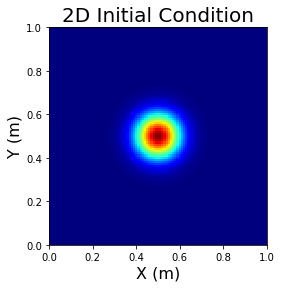

In [19]:
## . . Space axis parameters
xmin,xmax,ymin,ymax=0,1,0,1
nx,ny=101,101

xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
dx = xx[1]-xx[0]
dy = yy[1]-yy[0]

## . . Initial Condition
sigma=0.05
mx = (xmax-xmin)/2
my = (ymax-ymin)/2
U = np.zeros((nx,ny))

xxx, yyy = np.meshgrid(xx, yy, sparse=True)

U = np.exp(-(xxx-mx)**2/((2*sigma)**2)-(yyy-my)**2/((2*sigma)**2))

plt.figure()
plt.imshow(U,cmap='jet',extent=[xmin,xmax,ymin,ymax])
plt.xlabel('X (m)',fontsize=16);plt.ylabel('Y (m)',fontsize=16);
plt.title('2D Initial Condition',fontsize=20)
plt.show()

**Figure 9. 2D initial condition for the solution of the 2D diffusion-advection equation below.**

In [20]:
## . . Velocity components parameters
vx,vy = -0.1,-0.1 # velocity components (m/s)
K = 0.01 ## . . diffusivity (m^2/s)

# Boundary conditions on left, right, bottom and top
LB=RB=BB=TB=0 

## . . Time axis parameters
nt,dt=501,0.0125

## . . Solution space
p2d = np.zeros((nx,ny,nt))

## . . Loop over time
for i in range(nt):
    U = Solve_2D_Convection_Diffusion_homogeneous_Thomas(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB)
    p2d[:,:,i]=U

def convection_diffusion_2d_animate(i):
    global k
    ax1.clear()
    ax1.imshow(p2d[:,:,k],cmap='jet',extent=[xmin,xmax,ymin,ymax])
    ax1.grid(True)
    ax1.set(xlabel='X (m)',ylabel='Y (m)')
    ax1.set_title('2D Advection Solution',fontsize=20)
    k += kskip

## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig8,ax1 = plt.subplots(1)
fig8.subplots_adjust(0.1,0.1,0.9,0.9)
fig8.set_dpi(100)

## . . Call the animator.  
anim8 = animation.FuncAnimation(fig8,convection_diffusion_2d_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim8.save('./movies/Ex7_8.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex7_8.mp4" type="video/mp4">
</video>
""")

**Figure 10. Solution of the 2D advection-diffusion equation for the initial condition shown in Figure 9.**